In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
from glob import glob 
import matplotlib.pyplot as plt
import keras
from skimage.util import montage as montage2d
from skimage.io import imread
import seaborn as sns
from keras.optimizers import Adam
import tensorflow as tf
from keras import Input
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet152V2, InceptionV3, EfficientNetB7, MobileNetV3Small
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, Conv2D,MaxPooling2D,GlobalAveragePooling2D,AvgPool2D,multiply, LocallyConnected2D, Lambda, AvgPool2D


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
base_dir = os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities')
all_xray_images_dataframe = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_xray_images_dataframe.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
59109,00014626_005.png,Atelectasis|Infiltration,5,14626,44,F,PA,2992,2991,0.143,0.143,NaN
13375,00003478_008.png,No Finding,8,3478,22,M,AP,2500,2048,0.168,0.168,NaN
63732,00015732_014.png,Edema|Infiltration,14,15732,48,F,AP,2500,2048,0.168,0.168,NaN
94588,00024327_000.png,Infiltration,0,24327,30,M,PA,2992,2991,0.143,0.143,NaN
72541,00017871_001.png,No Finding,1,17871,27,F,PA,2438,2533,0.143,0.143,NaN


In [4]:
all_xray_images_dataframe['Finding Labels']

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object

# Preprocessing
Organize the files by cases with and without cardiomegaly

In [5]:
all_xray_images_dataframe = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_images_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_images_paths), ', Total Headers', all_xray_images_dataframe.shape[0])
all_xray_images_dataframe['path'] = all_xray_images_dataframe['Image Index'].map(all_images_paths.get)
all_xray_images_dataframe['Cardiomegaly'] = all_xray_images_dataframe['Finding Labels'].map(lambda x: 'Cardiomegaly' in x)
all_xray_images_dataframe['Patient Age'] = np.clip(all_xray_images_dataframe['Patient Age'], 5, 100)
all_xray_images_dataframe['Patient Male'] = all_xray_images_dataframe['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
all_xray_images_dataframe.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
85820,00021179_009.png,Nodule|Pneumothorax,9,21179,48,M,PA,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00021179_009.png,False,1.0
39168,00010270_005.png,No Finding,5,10270,17,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00010270_005.png,False,1.0
73086,00018006_003.png,No Finding,3,18006,60,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00018006_003.png,False,1.0


# Examine the distributions
Show how the data is distributed and why we need to balance it

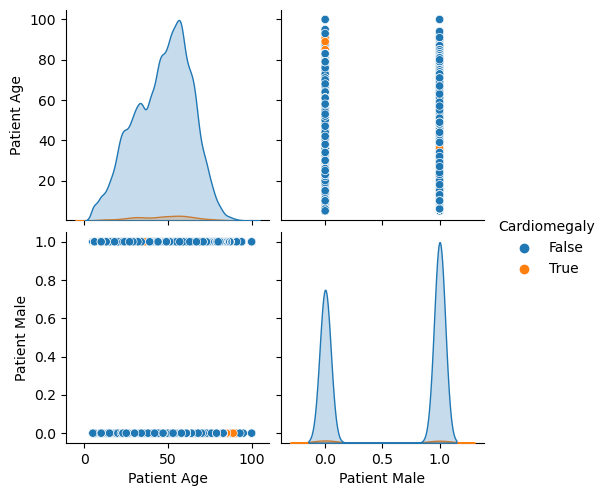

In [6]:
sns.pairplot(all_xray_images_dataframe[['Patient Age', 'Patient Male', 'Cardiomegaly']], hue='Cardiomegaly')

# Split Data into Training and Validation

False    11104
True      2776
Name: Cardiomegaly, dtype: int64


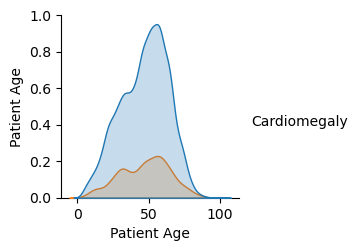

In [7]:
positive_cases = np.sum(all_xray_images_dataframe['Cardiomegaly']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_images_dataframe.groupby(['Patient Gender', 'Cardiomegaly']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Cardiomegaly'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Cardiomegaly']], hue='Cardiomegaly')

In [8]:
more_balanced_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
0,00018187_024.png,No Finding,24,18187,32,F,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00018187_024.png,False,0.0
1,00016991_003.png,No Finding,3,16991,31,F,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00016991_003.png,False,0.0
2,00023751_000.png,No Finding,0,23751,31,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_010/images/00023751_000.png,False,0.0
3,00021704_007.png,Infiltration,7,21704,26,F,PA,2992,2991,0.143,0.143,NaN,../input/data/images_010/images/00021704_007.png,False,0.0
4,00007272_000.png,No Finding,0,7272,60,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_004/images/00007272_000.png,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,00002256_013.png,Cardiomegaly,13,2256,41,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_002/images/00002256_013.png,True,1.0
13876,00019018_023.png,Cardiomegaly|Effusion,23,19018,27,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_009/images/00019018_023.png,True,1.0
13877,00017436_000.png,Cardiomegaly,0,17436,68,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_008/images/00017436_000.png,True,1.0
13878,00004737_007.png,Cardiomegaly|Effusion,7,4737,49,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_003/images/00004737_007.png,True,1.0


In [9]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Cardiomegaly', 'Patient Gender']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Cardiomegaly', 'Patient Gender']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Cardiomegaly'].value_counts())
print('test', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(1)

train 11104 validation 1665 test 1111
train False    8884
True     2220
Name: Cardiomegaly, dtype: int64
test False    888
True     223
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
13194,00010631_004.png,Cardiomegaly|Pleural_Thickening,4,10631,49,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00010631_004.png,True,1.0


In [10]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Cardiomegaly', 'Patient Gender']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.50, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Cardiomegaly', 'Patient Gender']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Cardiomegaly'].value_counts())
print('test', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(1)

train 11104 validation 1388 test 1388
train False    8884
True     2220
Name: Cardiomegaly, dtype: int64
test False    1110
True      278
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
11007,00001892_006.png,No Finding,6,1892,49,M,PA,2846,2991,0.143,0.143,NaN,../input/data/images_002/images/00001892_006.png,False,1.0


# Balance the distribution in the training set

In [11]:
train_df = raw_train_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(2220, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4440 Old Size: 11104


In [12]:
print('train', train_df['Cardiomegaly'].value_counts())

train False    2220
True     2220
Name: Cardiomegaly, dtype: int64


In [13]:
from keras.preprocessing.image import ImageDataGenerator
##from keras.applications.resnet_v2 import ResNet50 as PreTrainedModel, preprocess_input
#from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.applications.resnet_v2 import ResNet152V2 as PreTrainedModel, preprocess_input
IMG_SIZE = (224, 224) # size that ResNet152V2 expects
image_data_generator = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=False, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                             preprocessing_function=preprocess_input)

In [14]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(in_df,
                                              x_col=path_col,
                                              y_col=y_col,
                                     class_mode = 'raw',
                                    **dflow_args)
    return df_gen

In [15]:
train_gen = flow_from_dataframe(image_data_generator, train_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

valid_gen = flow_from_dataframe(image_data_generator, valid_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) 
test_X, test_Y = next(flow_from_dataframe(image_data_generator, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1388)) # one big batch
# used a fixed dataset for final evaluation
final_test_X, final_test_Y = next(flow_from_dataframe(image_data_generator, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1388)) # one big batch

Found 4440 validated image filenames.
Found 1388 validated image filenames.
Found 1388 validated image filenames.
Found 1388 validated image filenames.


In [16]:
t_x, t_y = next(train_gen)
t_y

array([False, False, False, False,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True])

(16, 224, 224, 3)
[False False False  True False  True  True False False  True False False
  True  True  True  True]


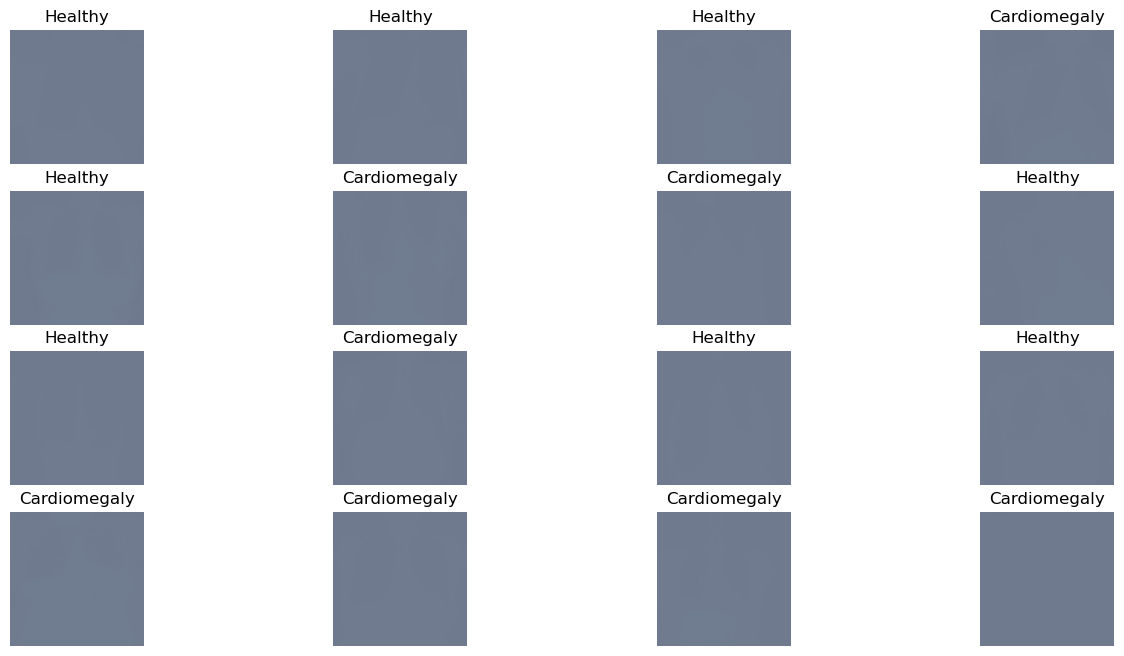

In [17]:
t_x, t_y = next(train_gen)
print(t_x.shape)
print(t_y)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % ('Cardiomegaly' if c_y else 'Healthy'))
    c_ax.axis('off')

In [18]:
base_pretrained_model = PreTrainedModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_pretrained_model.summary()

In [22]:
model = keras.models.Sequential()
model.add(base_pretrained_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_4 (Dropout)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 100)               10035300  
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
 dense_8 (Dense)             (None, 1)                

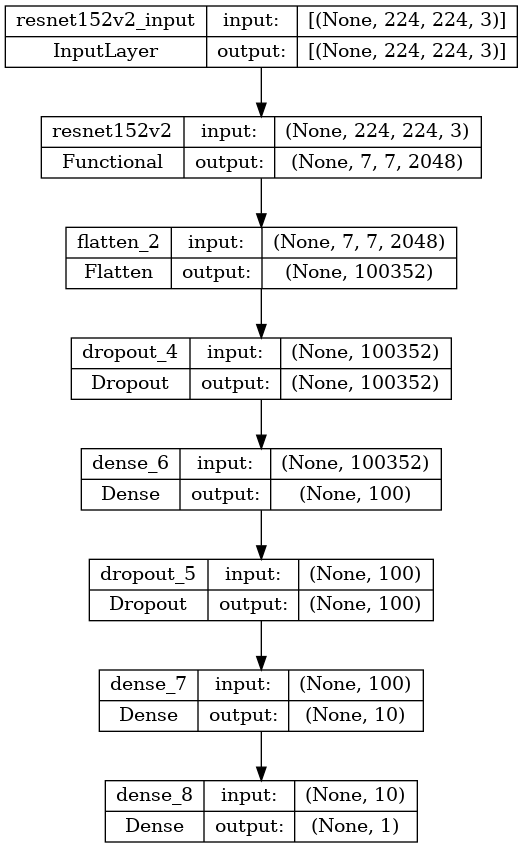

In [23]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model, show_shapes=True).create_png())

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_attn_test_valid')

modelCheckPoint = ModelCheckpoint(weight_path, monitor='val_binary_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)


reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_binary_accuracy", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [modelCheckPoint, early, reduceLROnPlateau]

In [25]:
train_gen.batch_size = 24
model.fit_generator(train_gen, 
                      validation_data = (test_X, test_Y), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 30, 
                      callbacks = callbacks_list,
                      workers = 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 244.8985 - binary_accuracy: 0.5052
Epoch 1: val_loss improved from inf to 0.67746, saving model to cardio_attn_weights.best.hdf5
185/185 [==============================] - 127s 577ms/step - loss: 244.8985 - binary_accuracy: 0.5052 - val_loss: 0.6775 - val_binary_accuracy: 0.8075 - lr: 0.0010
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 37.0525 - binary_accuracy: 0.4910
Epoch 2: val_loss did not improve from 0.67746
185/185 [==============================] - 97s 518ms/step - loss: 37.0525 - binary_accuracy: 0.4910 - val_loss: 0.7624 - val_binary_accuracy: 0.5225 - lr: 0.0010
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 20.7749 - binary_accuracy: 0.4930
Epoch 3: val_loss improved from 0.67746 to 0.67483, saving model to cardio_attn_weights.best.hdf5
185/185 [==============================] - 100s 533ms/step - loss: 20.7749 - binary_accuracy: 0.4930 - val_loss: 0.6748 - 

# No improvement in learning 

## Attention Model

The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP. It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.


## Basic Preprocessing
Here we take the output of the pretrained model and apply BatchNormalization

In [24]:
t_x.shape[1:]

(224, 224, 3)

In [25]:
base_pretrained_model(tf.keras.Input(t_x.shape[1:]))

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'resnet152v2')>

In [26]:
pretrained_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pretrained_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
batchNormalised_features = BatchNormalization(name='Features_BN')(pretrained_features)

In [27]:
attention_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(batchNormalised_features)
attention_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attention_layer)
attention_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attention_layer)
attention_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attention_layer) # smooth results
attention_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid',
                   name='AttentionMap2D')(attention_layer)

## Rescale Attention
We rescale the feature dimension back out to the original number of features (instead of just 1) by using a hard-coded convolution.

In [28]:
up_c2_w = np.ones((1, 1, 1, pretrained_depth))
up_c2 = Conv2D(pretrained_depth, kernel_size = (1,1), padding = 'same', name='UpscaleAttention',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attention_layer = up_c2(attention_layer)

# Global Weighted Average Pooling
We now want to use the attention layer to weight the regions we want during the average pooling. A standard average pooling layer is poorly suited to this task since many of the values (presumably) will be zero and they will be counted. So we hand-rig a 'weighted average pooling' where we multiply the attention by the features and then divide by the sum of the attention 
The formula for weighted average from [Wikipedia](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)
$$ \bar{x} = \frac{ \sum\limits_{i=1}^n w_i x_i}{\sum\limits_{i=1}^n w_i} $$
What we do is
$$ \text{GWAP}(x, y, d) = \frac{ \sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d) \text{Feature}(x,y,d)} {\sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d)} $$

In [29]:
mask_features = multiply([attention_layer, batchNormalised_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attention_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

## Dropout and Classification
We know take the output of this global weighted-average pooling and go to a classification with dropout and two fully connected layers

In [30]:
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

attention_model = Model(inputs = [pretrained_features], outputs = [out_layer], name = 'attention_model')

attention_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])

attention_model.summary()

Model: "attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feature_input (InputLayer)     [(None, 7, 7, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 Features_BN (BatchNormalizatio  (None, 7, 7, 2048)  8192        ['feature_input[0][0]']          
 n)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 7, 7, 128)    262272      ['Features_BN[0][0]']            
                                                                                    

## Model Architecture
We can show the whole model below

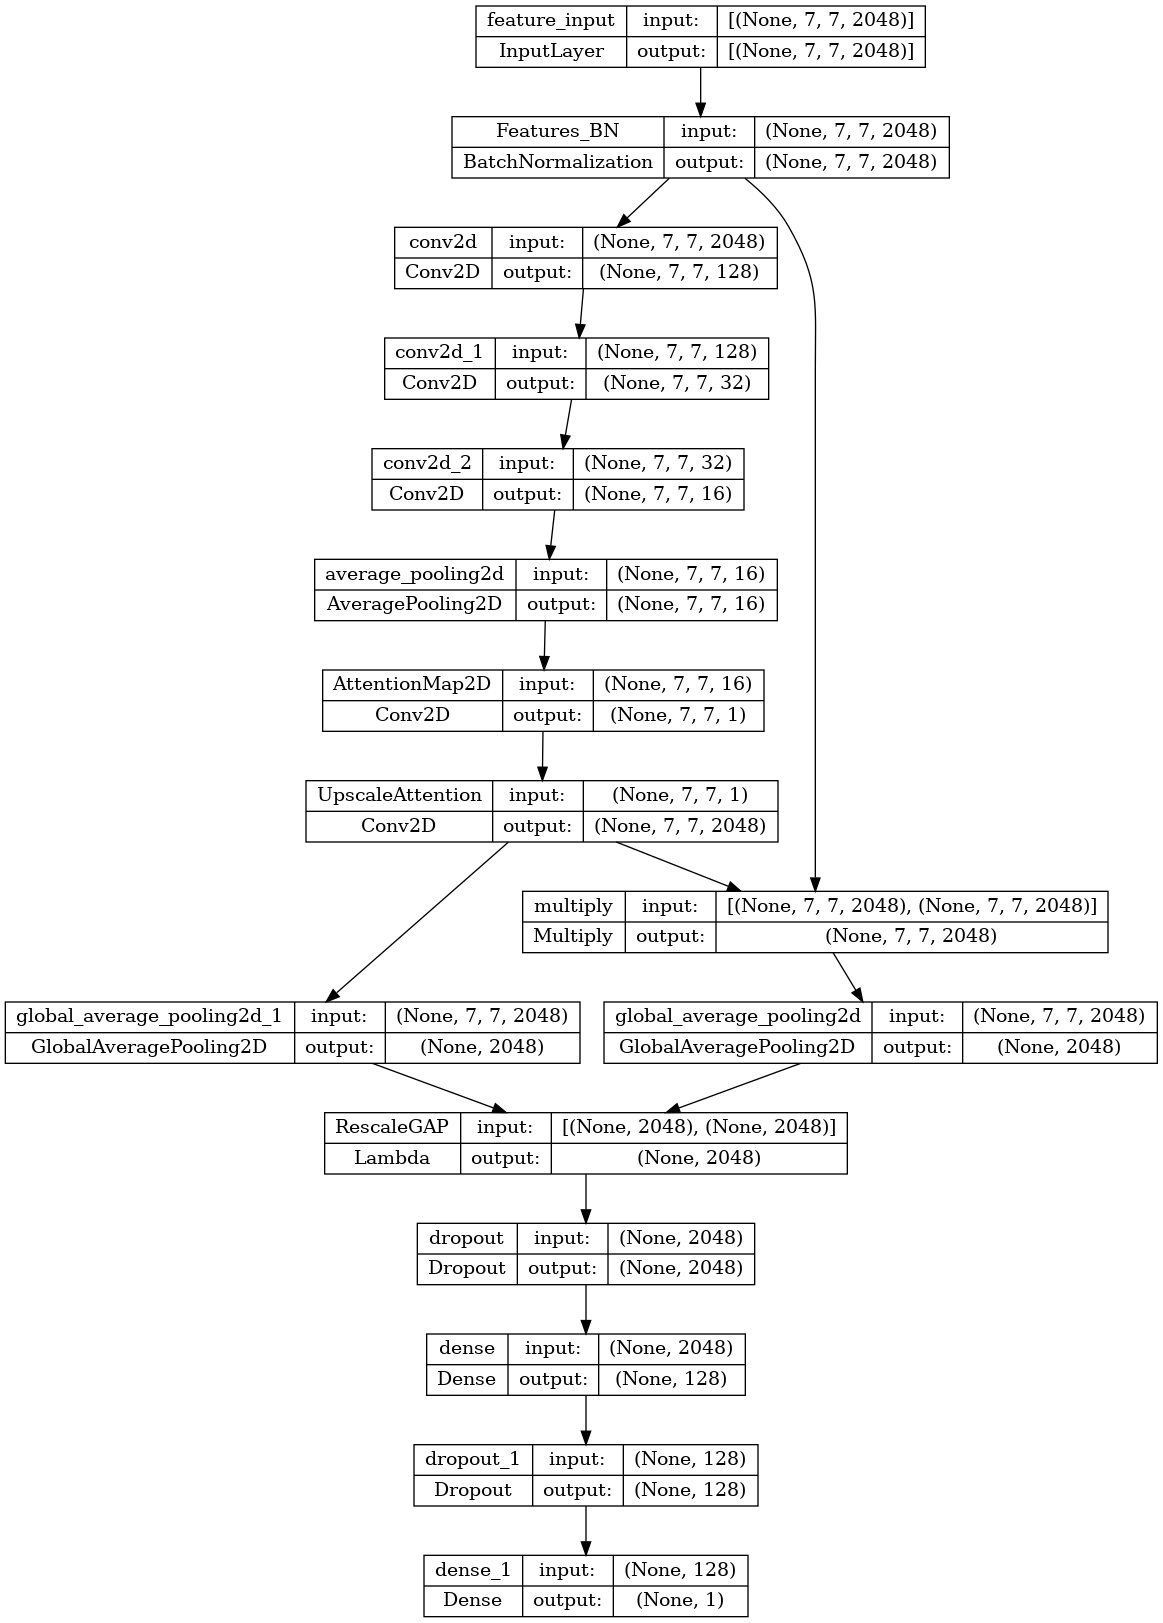

In [31]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(attention_model, show_shapes=True).create_png())

## Build the whole model
We build the whole model and fine-tune the results (much lower learning rate)

In [32]:
from keras.models import Sequential
from keras.optimizers import Adam
combined_Model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
combined_Model.add(base_pretrained_model)
combined_Model.add(attention_model)
combined_Model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])
combined_Model.summary()

Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 attention_model (Functional  (None, 1)                539586    
 )                                                               
                                                                 
Total params: 58,871,234
Trainable params: 533,442
Non-trainable params: 58,337,792
_________________________________________________________________


In [ ]:
combined_Model.fit_generator(train_gen, 
                      validation_data = (test_X, test_Y), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 2, 
                      callbacks = callbacks_list,
                      workers = 3)

# Image Size & training set manipulation to see if it has any effect 

In [33]:
train_gen.batch_size = 24
history = combined_Model.fit_generator(train_gen, 
                      validation_data = (test_X, test_Y), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 100, 
                      callbacks = callbacks_list,
                      workers = 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
185/185 [==============================] - ETA: 0s - loss: 0.6984 - binary_accuracy: 0.6162
Epoch 1: val_binary_accuracy improved from -inf to 0.72695, saving model to cardio_attn_test_valid_weights.best.hdf5
185/185 [==============================] - 124s 572ms/step - loss: 0.6984 - binary_accuracy: 0.6162 - val_loss: 0.5243 - val_binary_accuracy: 0.7269 - lr: 0.0010
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 0.6250 - binary_accuracy: 0.6592
Epoch 2: val_binary_accuracy did not improve from 0.72695
185/185 [==============================] - 101s 540ms/step - loss: 0.6250 - binary_accuracy: 0.6592 - val_loss: 0.5273 - val_binary_accuracy: 0.7219 - lr: 0.0010
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.5881 - binary_accuracy: 0.6842
Epoch 4: val_binary_accuracy did not improve from 0.72695
185/185 [==============================] - 100s 535ms/step - loss: 0.5881 - binary_accuracy: 0.6842 - val_loss: 0.6852 - val_binary

In [40]:
np.save('history.npy',history.history)

In [41]:
combined_Model.load_weights(weight_path)

In [42]:
history1=np.load('/kaggle/working/history.npy',allow_pickle='TRUE').item()

In [43]:
pred_Y = combined_Model.predict(test_X, 
                          batch_size = 32, 
                          verbose = True)

44/44 [==============================] - 6s 127ms/step


              precision    recall  f1-score   support

     Healthy       0.90      0.82      0.85      1110
Cardiomegaly       0.46      0.62      0.53       278

    accuracy                           0.78      1388
   macro avg       0.68      0.72      0.69      1388
weighted avg       0.81      0.78      0.79      1388



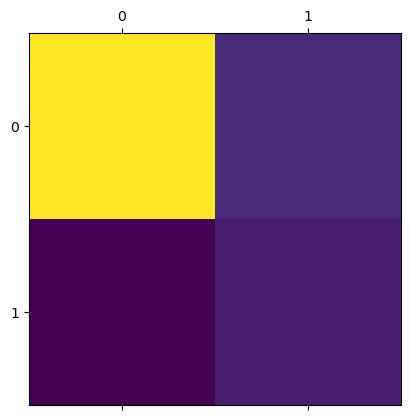

In [44]:
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'Cardiomegaly']))

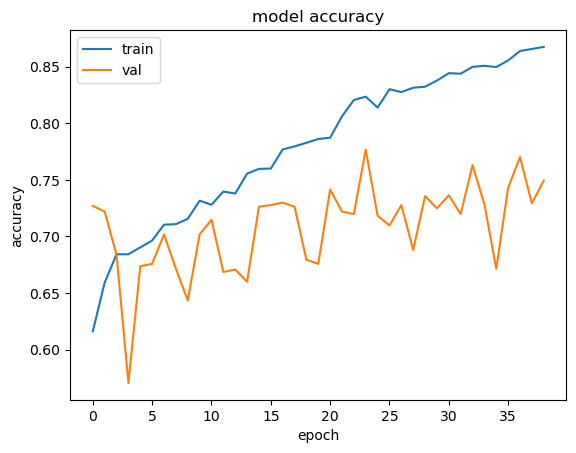

In [46]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

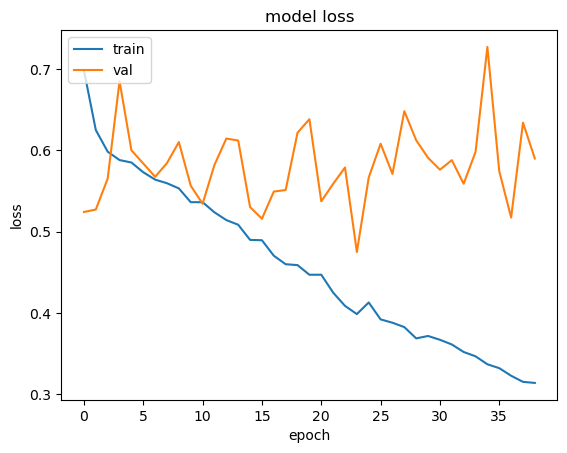

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test Results

In [48]:
final_pred_Y = combined_Model.predict(final_test_X, 
                                verbose = True, 
                                batch_size = 4)

347/347 [==============================] - 11s 32ms/step


              precision    recall  f1-score   support

     Healthy       0.90      0.81      0.85      1110
Cardiomegaly       0.46      0.63      0.53       278

    accuracy                           0.78      1388
   macro avg       0.68      0.72      0.69      1388
weighted avg       0.81      0.78      0.79      1388



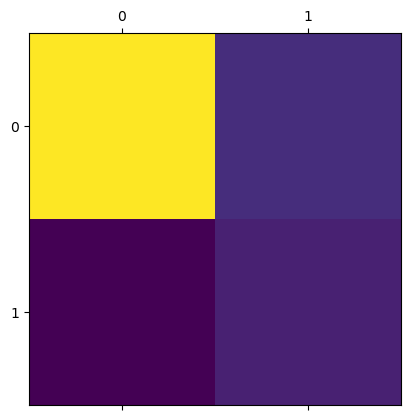

In [49]:
plt.matshow(confusion_matrix(final_test_Y, final_pred_Y>0.5))
print(classification_report(final_test_Y, final_pred_Y>0.5, target_names = ['Healthy', 'Cardiomegaly']))

In [50]:
def getPerformanceMetrics(real_values,pred_values,format):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Accuracy   = round( (TP+TN) / Population,4)
    PPV        = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    Sensitivity= round( TP / (TP+FN),4 )
    Specificity= round( TN / (TN+FP),4 )
    if format==1:
        performance_metrics = pd.DataFrame({'Metric': ['Accuracy','PPV','NPV','Sensitivity','Specificity'],
                                            'Value':[Accuracy,PPV,NPV,Sensitivity,Specificity]})
    else:
        performance_metrics = pd.DataFrame({'Accuracy':[Accuracy],'PPV':[PPV],'NPV':[NPV],'Sensitivity':[Sensitivity],'Specificity':[Specificity]})
        
    return performance_metrics

## Validation Metrics 

In [51]:
print(getPerformanceMetrics(test_Y, pred_Y>0.5,2))

   Accuracy     PPV    NPV  Sensitivity  Specificity
0    0.7767  0.4577  0.896       0.6223       0.8153


## Test Metrics

In [52]:
print(getPerformanceMetrics(final_test_Y,final_pred_Y>0.5,2))

   Accuracy     PPV     NPV  Sensitivity  Specificity
0    0.7767  0.4581  0.8976       0.6295       0.8135
